# Farm Insects Classification
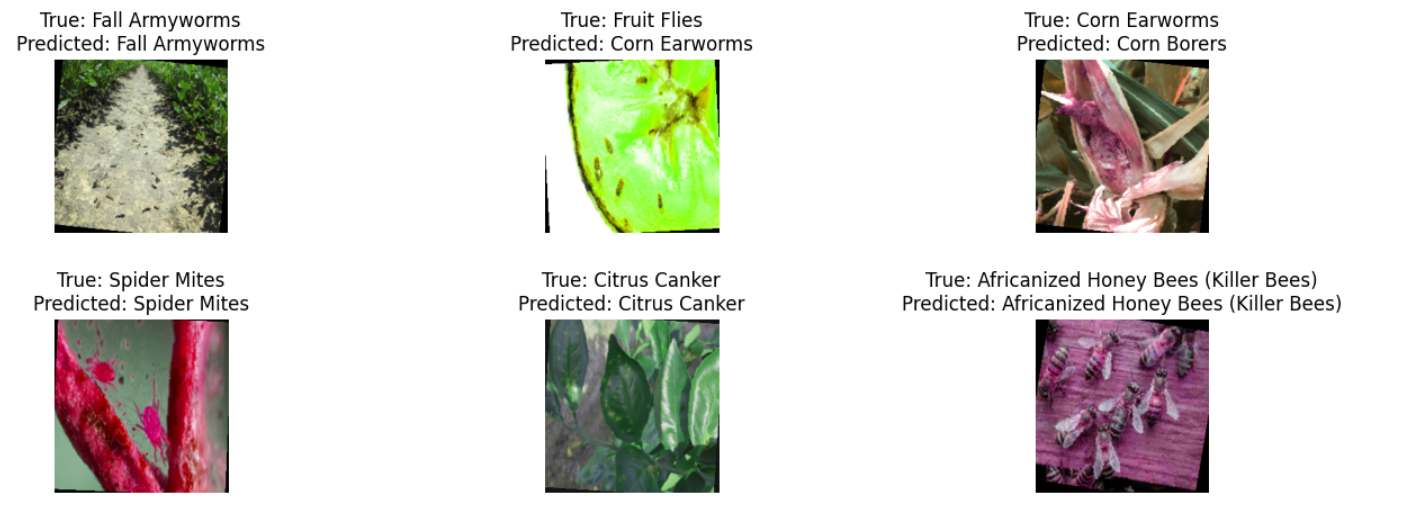
Kumpulan Data Gambar Serangga Peternakan Berbahaya adalah kumpulan gambar hasil kurasi yang menampilkan 15 jenis serangga berbeda yang biasa ditemukan di lingkungan pertanian. Kumpulan data ini menyediakan sumber daya visual yang berharga untuk mempelajari, mengidentifikasi, dan memahami karakteristik serangga yang berpotensi membahayakan ini. Setiap serangga diwakili oleh beberapa gambar berkualitas tinggi, menampilkan fitur, warna, dan pola yang berbeda.

Proses analisis dan klasifikasi gambar dalam kumpulan data ini menggunakan algoritma MobileNetV3 yang diimplementasikan dengan kerangka kerja PyTorch Lightning. Pendekatan ini memungkinkan penggunaan model jaringan saraf yang efisien dan responsif, memungkinkan identifikasi serangga dengan akurasi tinggi dalam waktu yang relatif singkat. Dengan demikian, pengguna dapat dengan mudah mengakses informasi penting tentang serangga peternakan berbahaya dan mengambil tindakan yang sesuai untuk melindungi pertanian.



## Import Data

In [1]:
!pip install torch torchvision pytorch-lightning wandb matplotlib numpy scikit-learn --quiet

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from sklearn.metrics import classification_report
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import wandb
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Konfigurasi WandB (Weight & Bias)
wandb.init(project='Farm_Insects_Classification_Improved')

# Tetapkan seed untuk reproduktibilitas
pl.seed_everything(42)

UsageError: api_key not configured (no-tty). call wandb.login(key=[your_api_key])

In [ ]:
# Ganti path sesuai dengan dataset yang Anda gunakan
data_path = '/kaggle/input/dangerous-insects-dataset/farm_insects'

# Mean dan standar deviasi ImageNet untuk normalisasi
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transformasi untuk data latih (dengan augmentasi dan normalisasi)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Transformasi untuk data validasi dan uji (hanya normalisasi)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Buat dataset PyTorch
train_dataset = datasets.ImageFolder(root=data_path, transform=train_transform)
val_test_dataset = datasets.ImageFolder(root=data_path, transform=val_test_transform)
class_names = train_dataset.classes

# Bagi dataset menjadi data latih, data validasi, dan data uji
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% data latih
val_size = int(0.1 * total_size)    # 10% data validasi
test_size = total_size - train_size - val_size  # 10% data uji

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# Buat DataLoader untuk data latih, data validasi, dan data uji
batch_size = 32
num_workers = 4  # Sesuaikan dengan jumlah CPU cores Anda

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [ ]:
# Fungsi untuk menampilkan batch gambar dari dataloader
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause sedikit agar plot ter-update

# Ambil satu batch dari dataloader
inputs, classes = next(iter(train_loader))

# Buat grid dari batch
out = make_grid(inputs)

# Tampilkan gambar-gambar
plt.figure(figsize=(15, 10))
imshow(out, title=[class_names[x] for x in classes])

## Model

In [ ]:
# Definisikan model
import torchvision.models as models

class MobileNetV3_Transformed(pl.LightningModule):
    def __init__(self, num_classes=15):
        super(MobileNetV3_Transformed, self).__init__()
        # Load pre-trained MobileNetV3
        self.model = models.mobilenet_v3_large(pretrained=True)
        
        # Ganti classifier untuk disesuaikan dengan jumlah kelas
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.sum(preds == labels.data) / len(labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.sum(preds == labels.data) / len(labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.sum(preds == labels.data) / len(labels)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

# Buat instance dari model
custom_model = MobileNetV3_Transformed(num_classes=len(class_names))


## Training

In [ ]:
# Tentukan callback untuk Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

In [ ]:
# Tentukan callback untuk WandB dengan menambahkan parameter tambahan
wandb_logger = pl.loggers.WandbLogger(
    project='Farm_Insects_Classification_Improved',
    log_model=True,
    save_code=True,
    tags=['mobilenetv3', 'farm insects', 'classification'],
)

# Inisialisasi trainer
trainer = pl.Trainer(
    max_epochs=50,
    logger=wandb_logger,
    callbacks=[early_stop_callback],
    accelerator='auto',
)

# Mulai pelatihan
trainer.fit(custom_model, train_loader, val_loader)

In [ ]:
# Evaluasi model pada data test
trainer.test(custom_model, test_loader)

In [ ]:
# Fungsi untuk invers normalisasi
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    std=[1/s for s in imagenet_std]
)

# Ambil satu batch dari dataloader latih
inputs, classes = next(iter(train_loader))

# Terapkan invers normalisasi
inputs_inv = torch.stack([inv_normalize(img) for img in inputs])

# Buat grid dari batch
out = make_grid(inputs_inv)

# Tampilkan gambar-gambar
plt.figure(figsize=(15, 10))
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Evaluasi model dan cetak classification report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

custom_model.to(device)
custom_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        outputs = custom_model(test_images)
        preds = outputs.argmax(dim=1)
        y_true.extend(test_labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [ ]:
# Fungsi untuk menampilkan hasil uji pada beberapa gambar dari dataloader
def show_test_results(loader, model, class_names, num_images=6):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs, labels = next(iter(loader))
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

    # Ambil invers normalisasi
    inputs_inv = torch.stack([inv_normalize(img) for img in inputs.cpu()])

    # Tentukan jumlah baris dan kolom pada subplot
    rows = 2
    cols = num_images // rows

    # Tampilkan beberapa gambar beserta hasil klasifikasinya
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image = inputs_inv[i].numpy().transpose((1, 2, 0))
        true_label = class_names[labels[i]]
        predicted_label = class_names[preds[i]]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.clip(image, 0, 1))
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Panggil fungsi show_test_results untuk menampilkan hasil uji
show_test_results(test_loader, custom_model, class_names, num_images=6)